In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import matplotlib as mpl
import glob
from matplotlib.path import Path
from collections import Counter
from tqdm import tqdm

In [ ]:
datapath = "/home/haue/repositories/Masters/data/" 
Al_path = datapath + "bananas/Al"
P_path = datapath + "bananas/P"
Si_path = datapath + "bananas/Si"
Mg_path = datapath + "bananas/Mg"
#outputdir = "/figure_output/"
cuts = datapath + "cuts/idcuts.root" 
bancuts = datapath + "cuts/banana_cuts.root"

Al_files = glob.glob(os.path.join(Al_path, "*mlio.root"))
P_files = glob.glob(os.path.join(P_path, "*mlio.root"))
Si_files = glob.glob(os.path.join(Si_path, "*mlio.root"))
Mg_files = glob.glob(os.path.join(Mg_path, "*mlio.root"))

In [ ]:
# Storing the data in a dictionary for easy access

### Should be a more intuitive version than the ones used in Bananachecks...

data_files = {
    "Al": Al_files,
    "P": P_files,
    "Mg": Mg_files,
    "Si": Si_files
}
data_collection = {
      "Al": {},
    "P": {},
    "Mg": {},
    "Si": {},
    "All": {}
}

data_collection = {isotope: {f"id{i}": {key: [] for key in ["E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"]} for i in range(4)} for isotope in data_files}
data_collection["All"] = {f"id{i}": {key: [] for key in ["E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"]} for i in range(4)}


for isotope, files in data_files.items():
    #file_progress = tqdm(files, desc=f"Processing {isotope}", unit="file", total=len(files), dynamic_ncols=True)
    file_progress = tqdm(files, desc=f"Processing {isotope}", unit="file", total=len(files), bar_format="{l_bar}{bar} {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]")

    for file in file_progress:
        
        ## accesses the tree "a" in the root file
        r = uproot.open(file)["a"]
        ##Dummy array
        dum = r.arrays(["id", "E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"])
        
        ## converts it to an awkward array
        ids = ak.flatten(dum["id"])
        Es = ak.nan_to_num(ak.flatten(dum["E"]) / 1e3)
        fEdeps = ak.nan_to_num(ak.flatten(dum["fEdep"]) / 1e3)
        bEdeps = ak.nan_to_num(ak.flatten(dum["bEdep"]) / 1e3)
        angles = ak.nan_to_num(np.rad2deg(ak.flatten(dum["angle"])))
        Edeps = ak.nan_to_num(ak.flatten(dum["Edep"]) / 1e3)
        FIs = ak.flatten(dum["FI"])
        BIs = ak.flatten(dum["BI"])
        
        ##Creates entries in data_collection for each key and for each detector for each key
        for i in range(4):
            mask = (ids==i)
            detector_name = f"id{i}"
            data_collection[isotope][detector_name]["E"].extend(Es[mask])
            data_collection[isotope][detector_name]["fEdep"].extend(fEdeps[mask])
            data_collection[isotope][detector_name]["bEdep"].extend(bEdeps[mask])
            data_collection[isotope][detector_name]["angle"].extend(angles[mask])
            data_collection[isotope][detector_name]["Edep"].extend(Edeps[mask])
            data_collection[isotope][detector_name]["FI"].extend(FIs[mask])
            data_collection[isotope][detector_name]["BI"].extend(BIs[mask])
        file_progress.set_postfix({"Completed": f"{file_progress.n}/{file_progress.total}"})
    #print(f"Processing done for {isotope}!")
    

tqdm.write("Combining all isotopes into 'All'...")      
## Create the "All" branch in data_collection
for i in range(4):
    detector_key = f"id{i}"
    for key in ["E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"]:
        data_collection["All"][detector_key][key] = sum((data_collection[isotope][detector_key][key] for isotope in data_files), [])

tqdm.write("✅ All data combined successfully!")


Processing Al:   0%|          | 0/56 [00:00<?, ?file/s]

Combining all isotopes into 'All'...
✅ All data combined successfully!


In [30]:
# Loading in cut values for regions of interest
cut = uproot.open(cuts)
#a for above
a1, b1 = cut["id0cut"].values()
a2, b2 = cut["id1cut"].values()
a3, b3 = cut["id2cut"].values()
aas = [a1/1e3, a2/1e3, a3/1e3]
bs = [b1/1e3, b2/1e3, b3/1e3]

bancut = uproot.open(bancuts)
#i for inside
i1, j1 = bancut["bananaU1"].values()
i2, j2 = bancut["bananaU2"].values()
i3, j3 = bancut["bananaU3"].values()
iis = [i1/1e3, i2/1e3, i3/1e3]
js = [j1/1e3, j2/1e3, j3/1e3]


In [49]:

abovebanana = np.column_stack((aas[0], bs[0]))
abovebanana_path = Path(abovebanana)    
inbanana = np.column_stack((iis[0], js[0]))
inbanana_path = Path(inbanana)

isotope = "Si"

points = np.column_stack((data_collection[isotope]["id0"]["bEdep"], data_collection[isotope]["id0"]["fEdep"]))
abovemask = abovebanana_path.contains_points(points)
inmask = inbanana_path.contains_points(points)

above_E = np.array(data_collection[isotope]["id0"]["E"])[abovemask]
above_fedep = np.array(data_collection[isotope]["id0"]["fEdep"])[abovemask]
above_bedep = np.array(data_collection[isotope]["id0"]["bEdep"])[abovemask]
in_fedep = np.array(data_collection[isotope]["id0"]["fEdep"])[inmask]
in_bedep = np.array(data_collection[isotope]["id0"]["bEdep"])[inmask]
in_E = np.array(data_collection[isotope]["id0"]["E"])[inmask]
 

Entries in cut region in banana:  112944
Entries in cut region above banana:  444



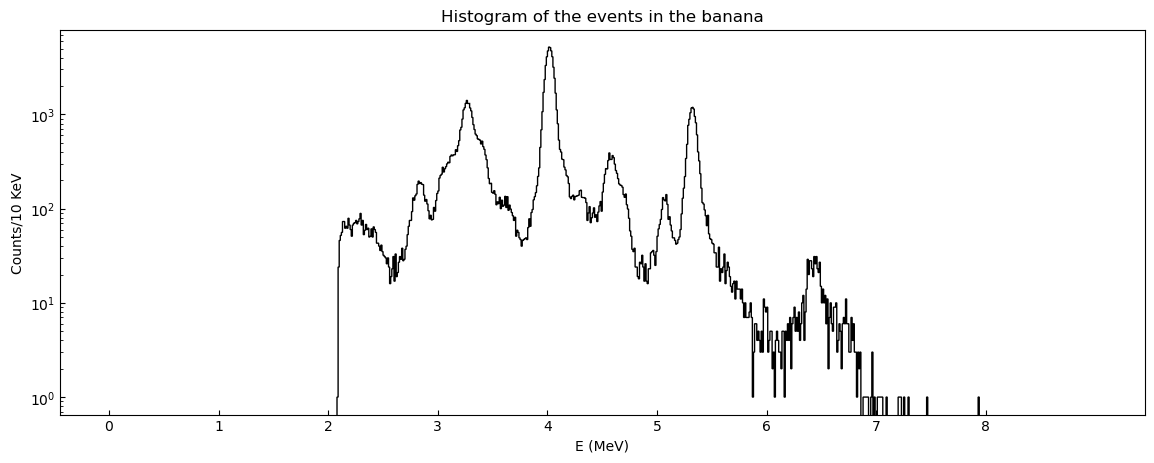

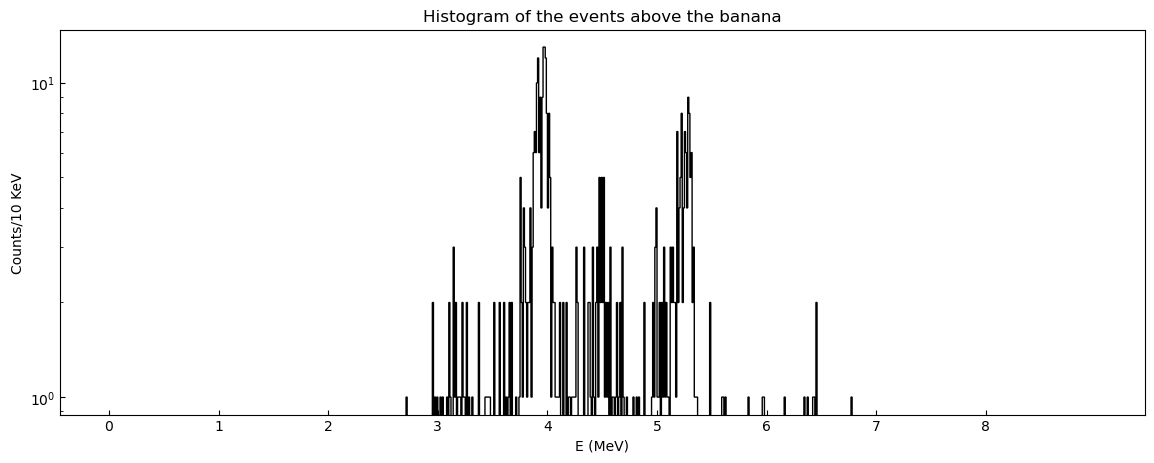

In [67]:

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

bin_width = 0.01 # keV
bins = np.arange(0, 9 + bin_width, bin_width)
sumE = [a+b for a,b in zip(in_fedep, in_bedep)]
plt.figure(figsize=(14,5))
plt.hist(sumE, bins=bins, histtype='step', color='k')
plt.yscale('log')
print("Entries in cut region in banana: ",len(in_fedep))
plt.title("Histogram of the events in the banana")
plt.xlabel("E (MeV)")
plt.ylabel("Counts/10 KeV")
plt.xticks(np.arange(0,9, 1))
#plt.show()

sume = [a+b for a,b in zip(above_fedep, above_bedep)]
plt.figure(figsize=(14,5))
plt.hist(sume, bins=bins, histtype='step', color='k')
plt.yscale('log')
print("Entries in cut region above banana: ", len(above_fedep))
plt.title("Histogram of the events above the banana")
plt.xlabel("E (MeV)")
plt.ylabel("Counts/10 KeV")
plt.xticks(np.arange(0,9, 1))
print()
##############################################################################3
#444 for Si 393 for P


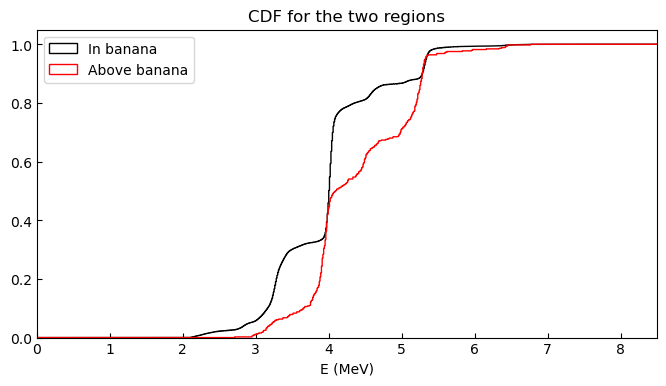

In [73]:
plt.figure(figsize=(8,4))
plt.hist(sumE, bins=bins, histtype='step', color='k', cumulative=True, label="In banana", density=True)
plt.hist(sume, bins=bins, histtype='step', color='r', cumulative=True, label="Above banana", density=True)
plt.xlabel("E (MeV)")
plt.legend(loc='upper left')
plt.xlim(0,8.5)
plt.xticks(np.arange(0,9,1))
plt.title("CDF for the two regions")
print()